In [1]:
%load_ext notexbook

%texify

In [2]:
%%writefile validation.py

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgb, rgb_to_hsv, hsv_to_rgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

plt.xkcd(scale=0.5)

p = sns.color_palette("colorblind")

TRUE_COLOR = p[1]
SAMPLES_COLOR = p[0]  #"steelblue"
POLY_3_COLOR = p[2]  #"darkorange"
POLY_15_COLOR = p[3]  #"darkgreen"
TRAIN_COLOR = p[4]  #"crimson"
TEST_COLOR = p[5]  #"darkolivegreen"

def true_fun(x):
    return np.cos(1.5 * np.pi * x)

def poly_fit(X, y, degree):
    pipeline = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LinearRegression(),
    )
    pipeline.fit(X, y)
    return pipeline

def start_plot():
    fig, ax = plt.subplots(constrained_layout=True)
    return fig, ax

def finalise_plot(ax):
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_xlim((0, 1))
    ax.set_ylim((-2, 5))
    ax.legend(loc="best")
    
def plot_model(ax, model, color, label="Model"):
    X_test = np.linspace(0, 1, 500)[:, np.newaxis]
    y_pred = model.predict(X_test)
    ax.plot(X_test, y_pred, label=label, color=color, linestyle="--")

def plot_true(ax):
    X_test = np.linspace(0, 1, 100)[:, np.newaxis]
    ax.plot(X_test, true_fun(X_test), label="True function", color=TRUE_COLOR)
    
def plot_samples(ax, X, y, label, color):
    edgecolor = hsv_to_rgb(rgb_to_hsv(to_rgb(color)) * [1.0, 0.9, 1.0])
    ax.scatter(X, y, edgecolor=edgecolor, facecolor=color, s=50, label=label, zorder=100)

Writing validation.py


In [4]:
import numpy as np
from validation import true_fun

rng = np.random.RandomState(0)

n_samples = 30

x = np.sort(rng.rand(n_samples))
X_fit = x[:, np.newaxis]
y_fit = true_fun(x) + rng.randn(n_samples) * 0.1

# Testing your model

To truly judge how good the model is, we need to compare it with some data and see how well it aligns (i.e. how well it would be able to predict it).

For example, imagine we have a model generating some data from a function which looks like:

In [5]:
from validation import start_plot, finalise_plot

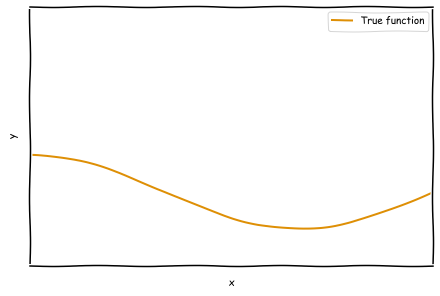

In [6]:
from validation import plot_true

fig, ax = start_plot()
plot_true(ax)
finalise_plot(ax)

We could now visualise the samples over the true model

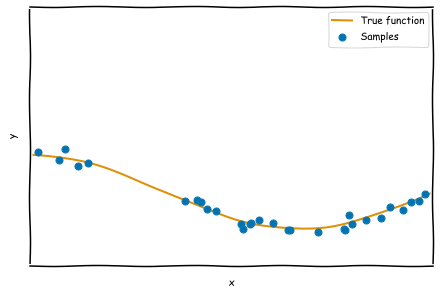

In [7]:
from validation import plot_samples, SAMPLES_COLOR

fig, ax = start_plot()
plot_true(ax)
plot_samples(ax, X_fit, y_fit, "Samples", SAMPLES_COLOR)
finalise_plot(ax)

### Fitting with different Degrees

We can fit this model with perhaps varying degrees of polynomial. 

Mathematically, if we increase the degree of polynomial far enough we can fit any function. 

For example, fitting the data with a 15<sup>th</sup>-order polynomial creates a model which goes through most of the data points but clearly represent the underlying model badly:

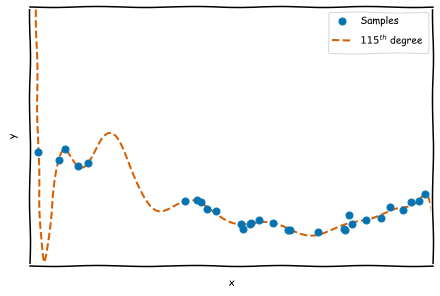

In [8]:
from validation import poly_fit, POLY_15_COLOR, plot_model

model = poly_fit(X_fit, y_fit, 15)

fig, ax = start_plot()
plot_samples(ax, X_fit, y_fit, "Samples", SAMPLES_COLOR)
plot_model(ax, model, POLY_15_COLOR, "$115^{th}$ degree")
finalise_plot(ax)

Here we can *see* that the model is not doing a good job of representing the underlying function (because we saw it above) but in the real world **you do not usually have the underlying model available**. 

In those cases overfitting is harder to see as it just manifests as a "well-performing" model. 

Let's try to fit with a polynomial of different degree, i.e. `3`

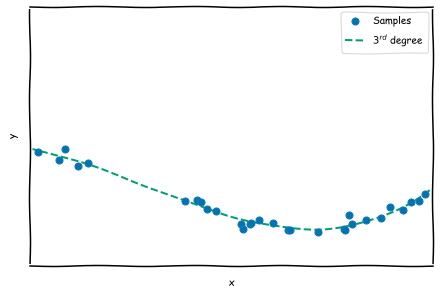

In [9]:
from validation import POLY_3_COLOR

model = poly_fit(X_fit, y_fit, 3)

fig, ax = start_plot()
plot_samples(ax, X_fit, y_fit, "Samples", SAMPLES_COLOR)
plot_model(ax, model, POLY_3_COLOR, "$3^{rd}$ degree")
finalise_plot(ax)

The simplest solution to overfitting is to fit your model with one subset of data and then **assess its quality with another subset**. 

From a ML perspective, this makes even more sense, since one of the most crucial point of ML method is **Generalisation**. 

Generalisation refers to the capability of a ML model to perform well on *unseen* data (i.e. data not seen in training) - all based on the assaumption that all data are _i.i.d._ (more on this in the ML evaluation class).

Bringing up our data from the first chapter again:

In [10]:
import pandas as pd

data = pd.read_csv("linear.csv")

X = data[["x"]]
y = data["y"]

scikit-learn provides a built-in function, [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), to split your data into a subset of data to fit with and a subset of data to test against:

<img src="images/train_test_split.svg" alt="train-test split" class="maxw70" />

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

`train_test_split` will split your data randomly and so to get a reproducible "random" split we set the `random_state` argument.

To see that `train` and `test` are taken from the same distribution let's plot them:

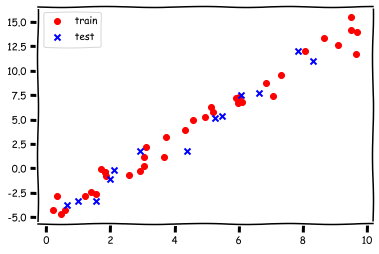

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(X_train, y_train, color="red", marker="o", label="train")
ax.scatter(X_test, y_test, color="blue", marker="x", label="test")
ax.legend()

Now that we have `train` and `test` we should only ever pass `train` to the `fit` function:

In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

LinearRegression()

To find out how good the fit was, we can call the [`score`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) method on the model. It is important here that we pass in our *test* data set as we expect that to provide an independent validation of the model.

In [14]:
model.score(X_test, y_test)

0.9676069631786152

A score of $1.0$ is a perfect match and anything less than that is less-well performing. A score of $0.97$ suggests we have a very good model.

Going back to our example from the start, we can see that when we compare our 3<sup>rd</sup>- and 15<sup>th</sup>-order polynomials against the *test data*, the 3<sup>rd</sup>-order score will be much better:

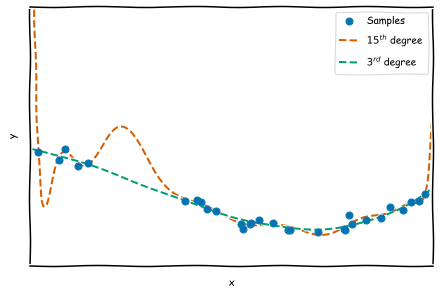

In [15]:
model_3 = poly_fit(X_fit, y_fit, 3)
model_15 = poly_fit(X_fit, y_fit, 14)

fig, ax = start_plot()
plot_samples(ax, X_fit, y_fit, "Samples", SAMPLES_COLOR)
plot_model(ax, model_15, POLY_15_COLOR, "$15^{th}$ degree")
plot_model(ax, model_3, POLY_3_COLOR, "$3^{rd}$ degree")
finalise_plot(ax)

### Exercise

- Load the [diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) from the scikit-learn collection. You can load the dataset into pandas with:
  ```python
  from sklearn.datasets import load_diabetes
  
  X, y = load_diabetes(as_frame=True, return_X_y=True)
  ```
- Split the data into `train` and `test` subsets
- Fit and plot the linear relationship between the "bmi" column (Body mass index) and the "target" column (quantitative measure of disease progression one year after baseline). 
- Calculate the score of the model against the `test` data set. 
- [<small>answer</small>](answers/answer_diabetes_regression.ipynb)

Next we will learn a little more about machine learning and how we can apply it to our own work.